In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_iroyqmk8.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
data = pd.read_csv('datasets/covtype.data', header=None)
data[54] = data[54].apply(lambda x: str(x))

curr_cols = list(data.columns)
curr_cols[-1] = 'target'
data.columns = curr_cols

data = data.sample(2000)

In [3]:
Y = patsy.dmatrix('target -1', data, return_type='dataframe')
Y.head()

,target[1],target[2],target[3],target[4],target[5],target[6],target[7]
568824,0.0,1.0,0.0,0.0,0.0,0.0,0.0
197778,1.0,0.0,0.0,0.0,0.0,0.0,0.0
519609,1.0,0.0,0.0,0.0,0.0,0.0,0.0
378723,0.0,0.0,0.0,0.0,0.0,0.0,1.0
202382,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
Y.sum(axis=0)

target[1]    740.0
target[2]    948.0
target[3]    139.0
target[4]     11.0
target[5]     26.0
target[6]     62.0
target[7]     74.0
dtype: float64

In [5]:
X = data[curr_cols[:-1]]
X.shape

(2000, 54)

In [6]:
Y.shape

(2000, 7)

In [7]:
print(X.shape[1], Y.shape[1])

54 7


In [8]:
def logit(X):
    return 1 / (1 + tt.exp(-X))

In [10]:
# Bayesian multi-class logistic regression to predict the target classes.
import theano.tensor as tt

with pm.Model() as model:
    # degrees_freedom = pm.HalfCauchy('degrees_freedom', 100)
    # weights = pm.StudentT('weights', 0, 100**2, degrees_freedom, shape=(X.shape[1],))
    # intercept = pm.StudentT('intercept', 0, 100**2, degrees_freedom)
    
    weights = pm.Normal('weights', 0, 100**2, shape=(X.shape[1], Y.shape[1]))
    intercept = pm.Normal('intercept', 0, 100**2)

    exponent = tt.dot(X, weights) + intercept
    p = logit(exponent)
    
    like = pm.Multinomial('likelihood', n=1, p=p, observed=Y)

In [11]:
with model:
    trace = pm.sample(10000, start=pm.find_MAP(), step=pm.Metropolis())

         Current function value: 5162.160535
         Iterations: 213
         Function evaluations: 311
         Gradient evaluations: 297


100%|██████████| 10500/10500 [00:30<00:00, 345.91it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa14deee2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa14a4edfd0>]], dtype=object)

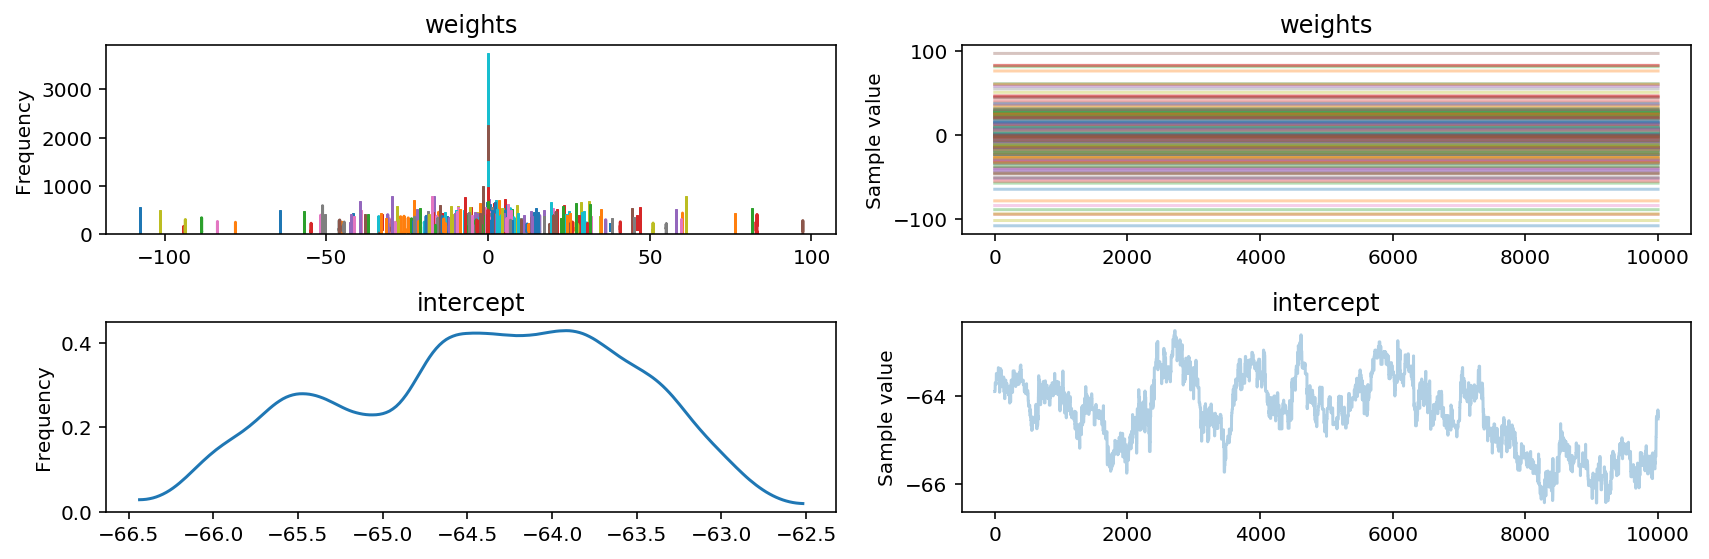

In [12]:
pm.traceplot(trace)

In [13]:
from sklearn.metrics import log_loss

In [15]:
with model:
    ppc_samps = pm.sample_ppc(trace, samples=100, )

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: object too deep for desired array